In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print (tf.__version__)

2.6.0


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data_dir='/content/drive/MyDrive/train/Untitled folder'
data_dir='/mnt/batch/tasks/shared/LS_root/mounts/clusters/arshakshan1/code/Users/arshakshan/simple_images'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

1368


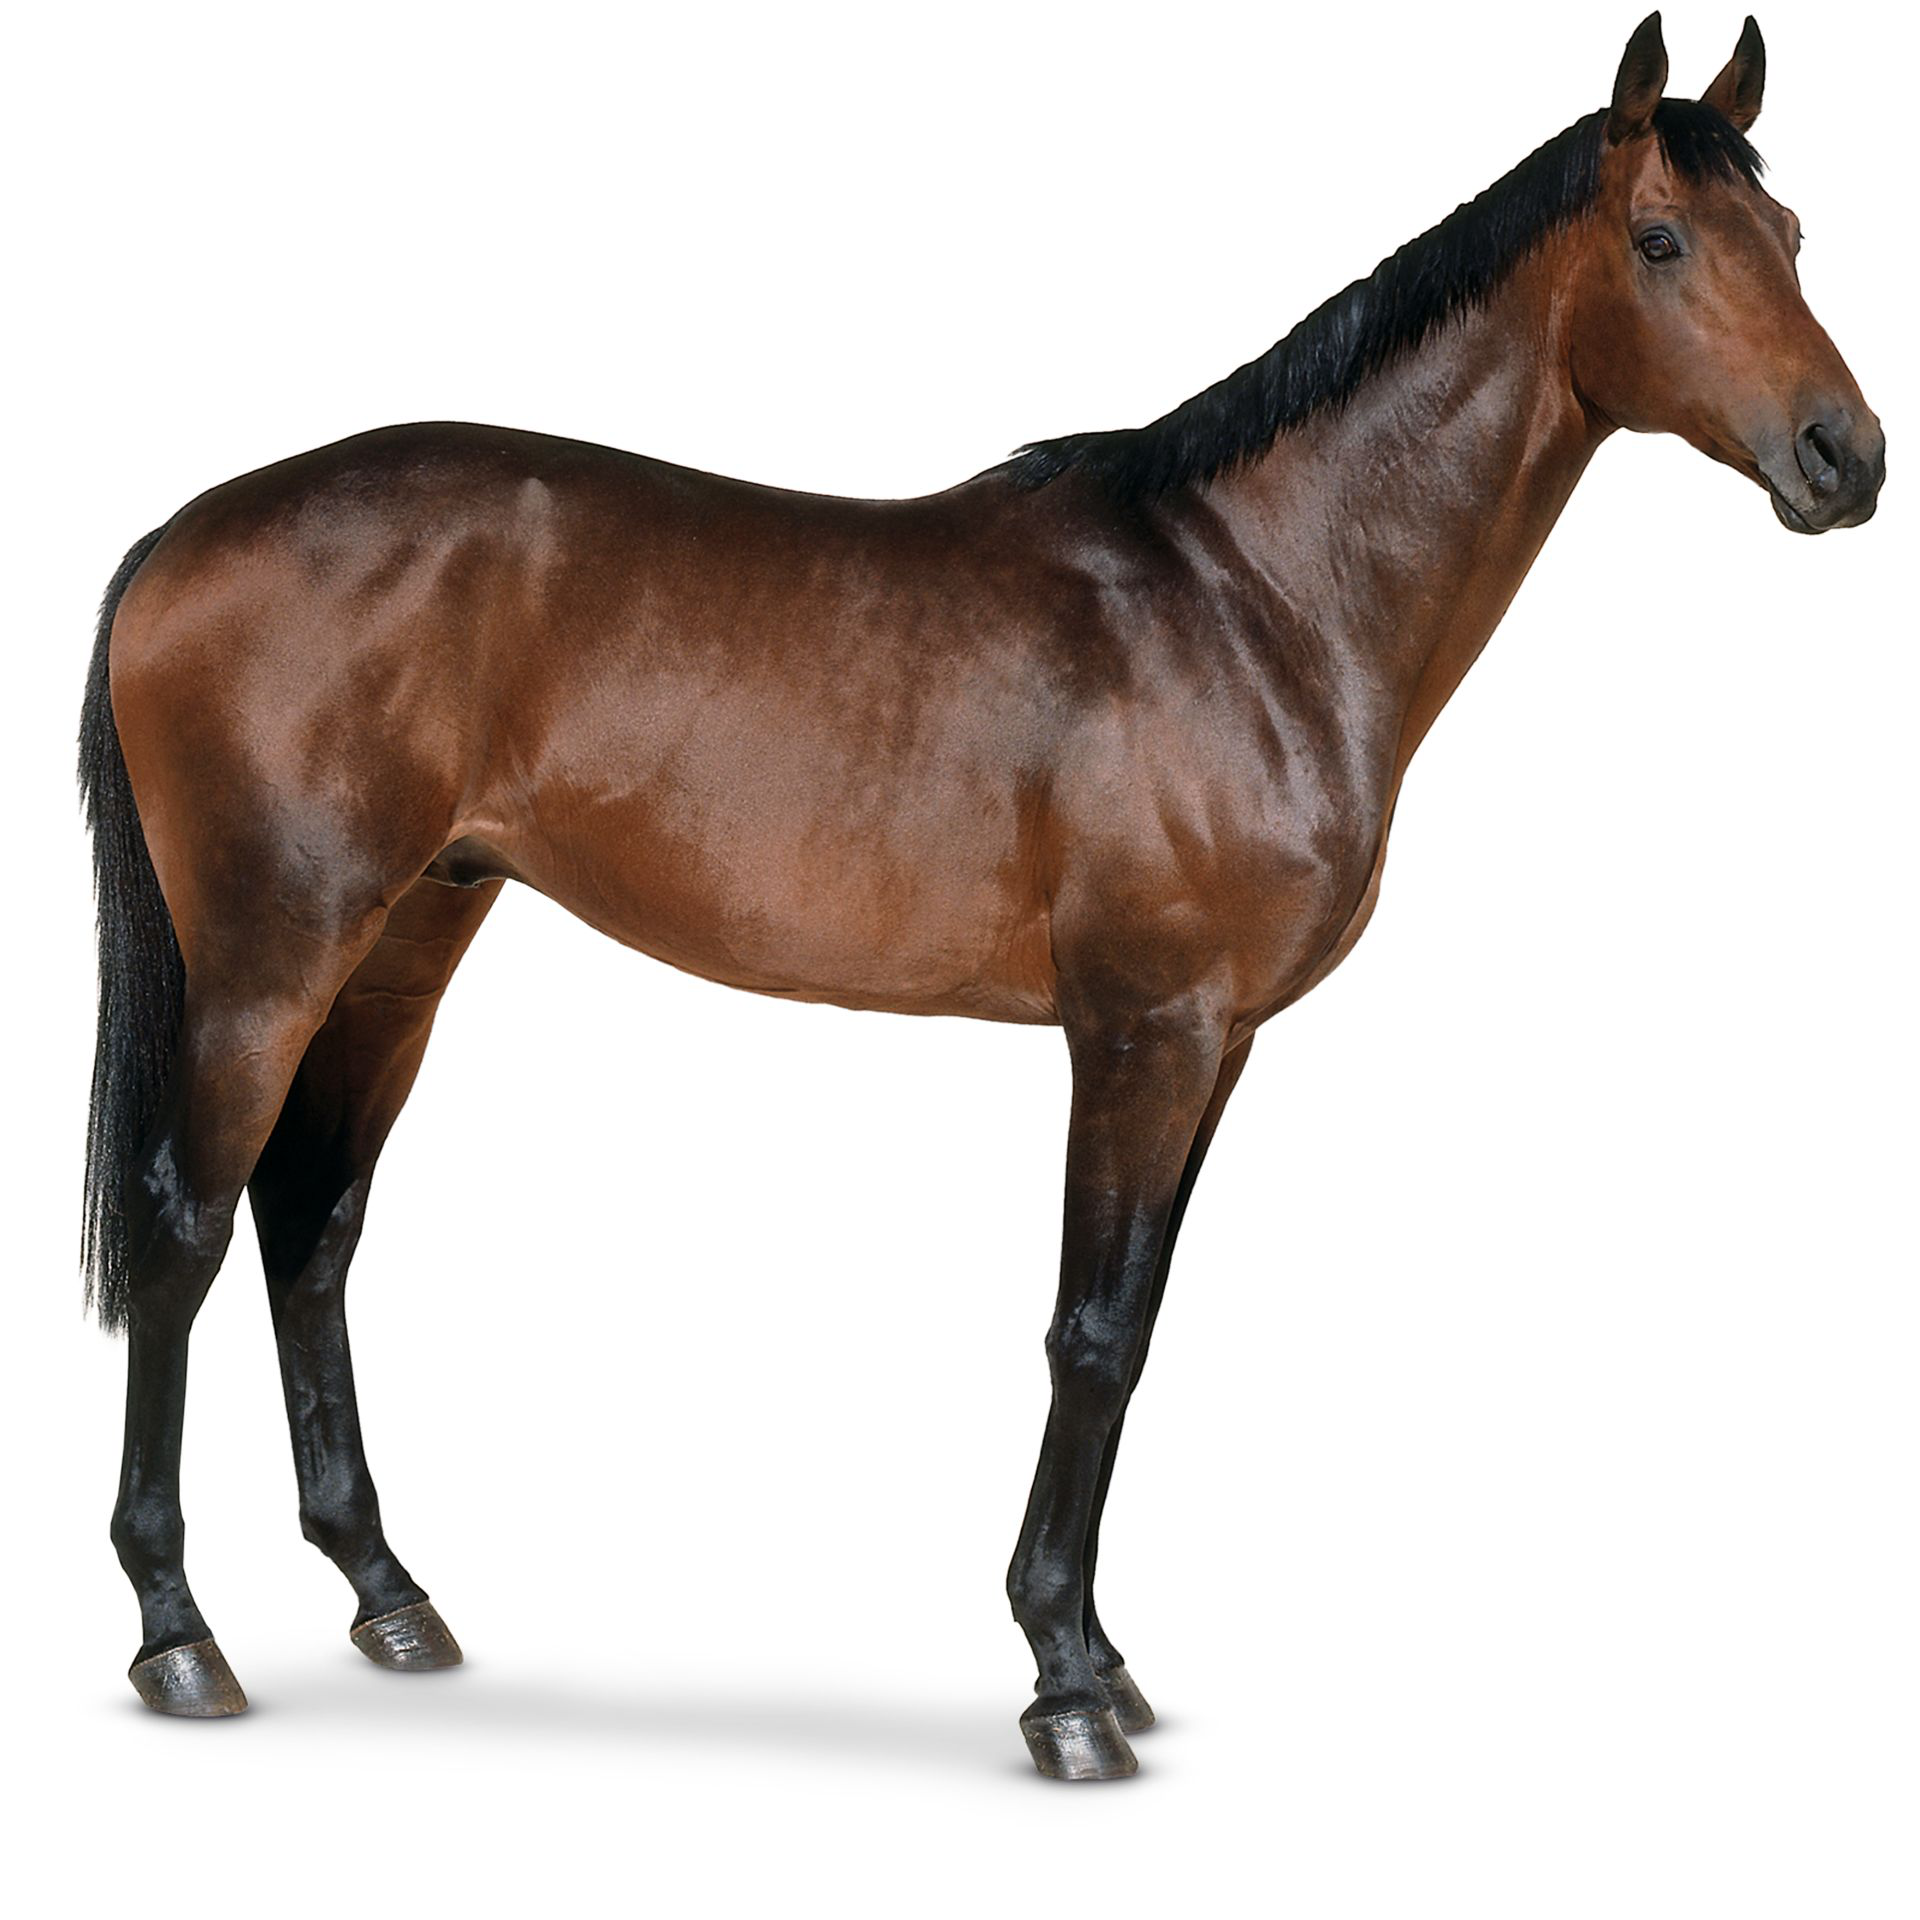

In [7]:
Horse = list(data_dir.glob('horse/*'))
PIL.Image.open(str(Horse[0]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 7 classes.
Using 1125 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1406 files belonging to 7 classes.
Using 281 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['cattle', 'horse', 'hyena', 'leopard', 'lion', 'tiger', 'wolf']


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9995027


In [15]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2


class AlexNet:
    @staticmethod
    def build(width, height, depth, classes, reg=0.0002):
        # Initialize model and input shape
        model = Sequential()
        inputShape = (width, height, depth)
        channelDimension = -1

        # Block 1:  first CONV => RELU => POOL layer set
        model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=inputShape, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        # Block 2:  second CONV => RELU => POOL layer set
        model.add(Conv2D(256, (5, 5), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: CONV => RELU => CONV => RELU => CONV => RELU
        model.add(Conv2D(384, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(384, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(4096, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())

        # Block #5: second set of FC => RELU layers
        model.add(Dense(4096, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Add Dense layer with Softmax classifier
        model.add(Dense(classes, kernel_regularizer=l2(reg)))
        model.add(Activation("softmax"))

        # Return Model
        return model  
 

In [16]:
a=AlexNet

In [17]:
model=a.build(img_width ,img_height,3,10)


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 45, 45, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 45, 45, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 45, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 256)       0

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
36/36 [==============================] - 38s 1s/step - loss: 6.0171 - accuracy: 0.2578 - val_loss: 999.8318 - val_accuracy: 0.1423
Epoch 2/10
36/36 [==============================] - 26s 723ms/step - loss: 4.8514 - accuracy: 0.3511 - val_loss: 52.6427 - val_accuracy: 0.1459
Epoch 3/10
36/36 [==============================] - 25s 708ms/step - loss: 4.3890 - accuracy: 0.4302 - val_loss: 19.2695 - val_accuracy: 0.1530
Epoch 4/10
36/36 [==============================] - 30s 828ms/step - loss: 4.2716 - accuracy: 0.4684 - val_loss: 9.8267 - val_accuracy: 0.1922
Epoch 5/10
36/36 [==============================] - 26s 714ms/step - loss: 4.0430 - accuracy: 0.5129 - val_loss: 10.1855 - val_accuracy: 0.2242
Epoch 6/10
36/36 [==============================] - 31s 881ms/step - loss: 3.6642 - accuracy: 0.6320 - val_l

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4943: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


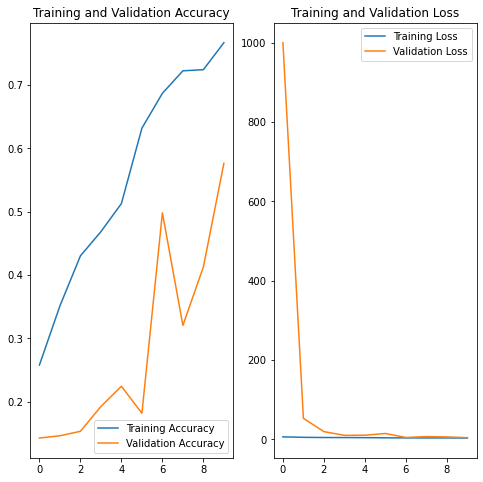

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
print("Accuracy : ",acc)

Accuracy :  [0.25777778029441833, 0.35111111402511597, 0.43022221326828003, 0.46844443678855896, 0.5128889083862305, 0.6320000290870667, 0.6871111392974854, 0.7226666808128357, 0.7244444489479065, 0.7671111226081848]


In [23]:
print("Validation_Accuracy : ",val_acc)

Validation_Accuracy :  [0.1423487514257431, 0.1459074765443802, 0.15302491188049316, 0.19217081367969513, 0.2241992950439453, 0.18149466812610626, 0.49822065234184265, 0.3202846944332123, 0.41281139850616455, 0.5765124559402466]


In [24]:
print("Loss : ", loss)

Loss :  [6.017085075378418, 4.851388931274414, 4.389039993286133, 4.271646499633789, 4.042954921722412, 3.664201021194458, 3.353283405303955, 3.255526065826416, 3.2967350482940674, 3.0670902729034424]


In [25]:
print("Validation Loss : ", val_loss)

Validation Loss :  [999.8318481445312, 52.6426887512207, 19.269453048706055, 9.826652526855469, 10.185500144958496, 14.554576873779297, 4.466256618499756, 6.776211261749268, 5.827936172485352, 4.074410438537598]
